In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imgrvt as rvt
import pims
import trackpy as tp
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel
from matplotlib.patches import Circle
%config InlineBackend.figure_format='retina'
from scipy.signal import find_peaks
from scipy.signal import peak_widths
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rc('xtick', labelsize=8)      # fontsize of the tick labels
plt.rc('ytick', labelsize=8)      # fontsize of the tick labels 
from sympy import *
cmap = matplotlib.colormaps['viridis']
cmap
from colormath.color_objects import XYZColor, sRGBColor
from colormath.color_conversions import convert_color
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import time
from sklearn.gaussian_process.kernels import RBF
from scipy.interpolate import CubicSpline
tab10 = plt.get_cmap("tab10")
viridis = plt.get_cmap("viridis")
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import LSQUnivariateSpline
import seaborn as sns

Frame([[84, 87, 87, ..., 83, 84, 85],
       [82, 84, 85, ..., 83, 84, 84],
       [86, 86, 86, ..., 87, 85, 86],
       ...,
       [87, 86, 88, ..., 84, 83, 85],
       [87, 86, 87, ..., 89, 86, 85],
       [88, 87, 88, ..., 88, 88, 86]], dtype=uint8)
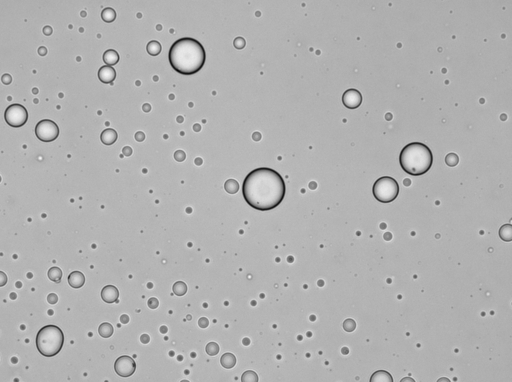

In [302]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

frames = gray(pims.open('24.07.08 trial 3 f01 renamed/*.png'))
Lt = len(frames)
frames[0]


In [303]:
Lt

100

In [304]:
def plot_comparison(src, results, titles=None): # plot several images to compare different RVT parameters
    nres=len(results)
    _,axes=plt.subplots(1,nres+1,figsize=(4*nres+4,3))
    axes[0].imshow(src,cmap="gray")
    axes[0].set_title("Source")
    for ax,res,t in zip(axes[1:],results,titles or [None]*nres):
        ax.imshow(res,cmap="inferno")
        if t:
            ax.set_title(t)

Frame([[120, 121, 120, ..., 101,  99, 103],
       [119, 120, 117, ...,  99,  96,  99],
       [120, 122, 120, ..., 104, 101, 101],
       ...,
       [133, 132, 136, ..., 106, 104, 106],
       [132, 133, 132, ..., 107, 105, 104],
       [132, 132, 134, ..., 105, 106, 105]], dtype=uint8)
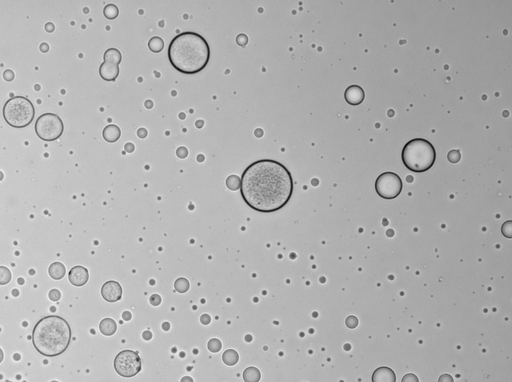

In [324]:
Ly,Lx = frames[0].shape
start = 45
xsize = 2080
ysize = 1552
xmin = 0
ymin = 0
img = frames[start][ymin:ymin+ysize, xmin:xmin+xsize]
img

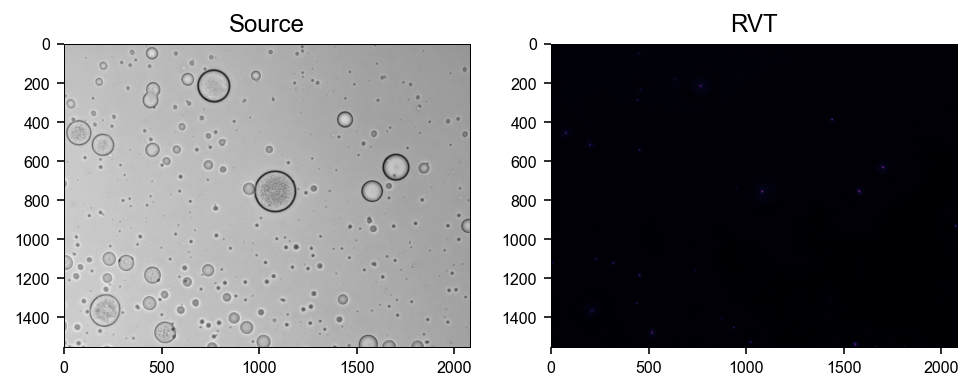

In [325]:
rmin = 30
rmax = 150
highpass_size = 1
kind = 'normalized'
img_rvt = rvt.rvt(img, rmin=rmin, rmax=rmax, highpass_size=highpass_size, kind=kind)
plot_comparison(img, [img_rvt], ["RVT"])

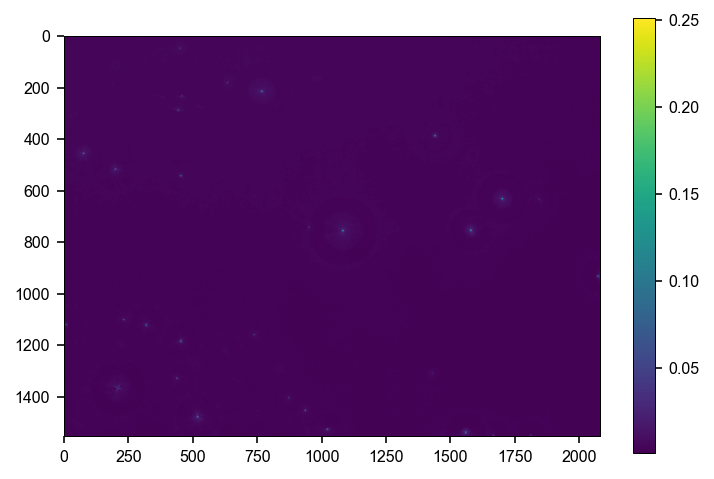

In [326]:
plt.imshow(img_rvt)
plt.colorbar();

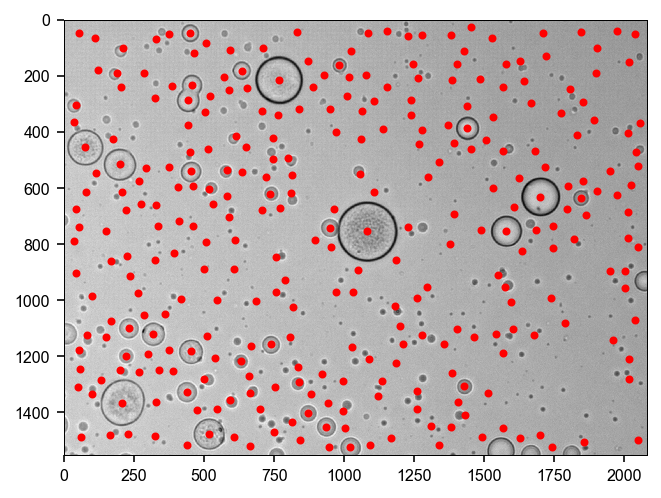

In [327]:
diameter = 3
separation = 50
f = tp.locate(img_rvt, diameter, preprocess=False, separation=separation)
tp.annotate(f, img, plot_style={'marker':'.','markersize':4});

(array([[1552.,    0.,    0., ...,    0.,    0.,    0.],
        [1552.,    0.,    0., ...,    0.,    0.,    0.],
        [1552.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [1552.,    0.,    0., ...,    0.,    0.,    0.],
        [1552.,    0.,    0., ...,    0.,    0.,    0.],
        [1552.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6]),
 <a list of 2080 BarContainer objects>)

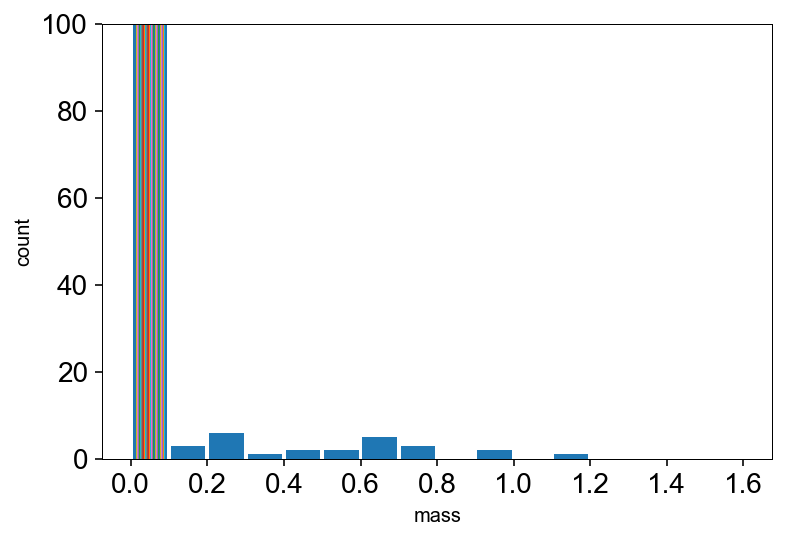

In [328]:
n_bins = 16;
range = (0,1.6)
plt.hist(f['mass'], bins = n_bins, range = range, rwidth = 0.9)
plt.xlabel('mass');
plt.ylabel('count');


plt.ylim(0,100)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.hist(img_rvt, n_bins, range = range)

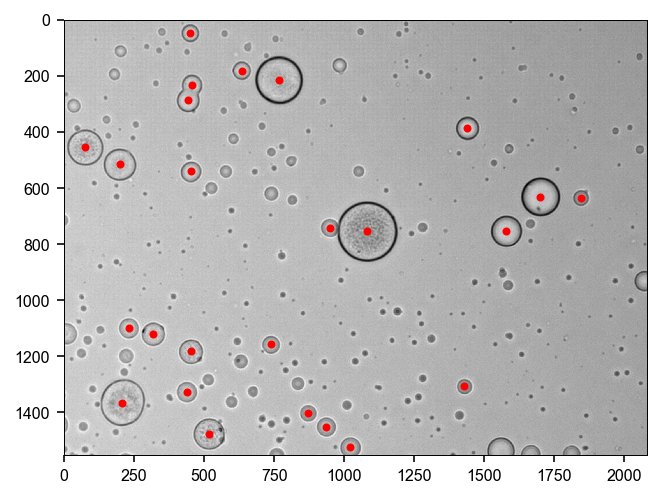

In [329]:
diameter = 3
minmass = 0.1
separation = 50
f = tp.locate(img_rvt, diameter, preprocess=False, minmass=minmass, separation=separation) #topn = 20
tp.annotate(f, img, plot_style={'marker':'.','markersize':4});

In [236]:
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
37,137.965870,1846.994027,0.714218,0.884547,0.279171,0.155397,0.715981,NaN
138,467.011765,1611.948235,0.517991,0.881176,0.293939,0.115786,0.519430,NaN
203,679.041379,618.024138,0.176726,0.872966,0.316742,0.042049,0.178400,NaN
210,716.988999,1462.017602,0.553946,0.883786,0.288732,0.121271,0.555112,NaN
247,838.988166,1085.970414,0.308966,0.882662,0.281013,0.068253,0.309810,NaN


# Process Video (all Drops)

In [250]:
start = 0
stop = 100

In [251]:
# define parameters
rmin = 30
rmax = 90
highpass_size = 1
kind = 'normalized'
diameter = 3
minmass = 0.1
separation = 50
wsize = 120

In [252]:
# only adds outputs of rvt.rvt fucntion that identifies drop centers to rvt.imgs folder 
imgs = []
rvt_imgs = []
finish = len(frames)
for frame in frames[start:stop]:
    img = frame[ymin:ymin+ysize, xmin:xmin+xsize]
    rvt_img = rvt.rvt(img, rmin=rmin, rmax=rmax, highpass_size=highpass_size, kind=kind)
    imgs.append(img)
    rvt_imgs.append(rvt_img)
    if len(rvt_imgs)%50==0:
        print(len(rvt_imgs))
        
# % is Modulo Operator - divides LHS by RHS

50
100


In [253]:
len(rvt_imgs)

100

In [254]:
# tracks drops centers for all images present in rvt.imgs
df_tp_batch = tp.batch(rvt_imgs, diameter, preprocess=False, minmass=minmass, separation=separation)
df_tp_batch.head()

Frame 99: 9 features


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,95.021236,85.992278,0.575268,0.882039,0.287841,0.127714,0.576821,NaN,0
1,152.013953,1827.009302,0.716308,0.884842,0.275248,0.155478,0.718600,NaN,0
2,379.000000,1611.016529,0.134377,0.890724,0.260417,0.027764,0.137134,NaN,0
3,487.981297,1597.024938,0.890665,0.884192,0.280702,0.194347,0.893136,NaN,0
4,701.053367,603.974587,0.874007,0.881837,0.285948,0.194347,0.877566,NaN,0


In [255]:
diameter

3

In [256]:
# link particles using tp.link_df
linked_droplets = tp.link_df(df_tp_batch, search_range=70, memory=3)

# search_rangefloat or tuple the maximum distance features can move between frames, optionally per dimension
# memoryinteger, optional - the maximum number of frames during which a feature can vanish, then reappear nearby, and be considered the same particle. 0 by default.

# remove drops near the edge
idx = (linked_droplets['x'] >= wsize ) & (linked_droplets['x'] < xsize - wsize - 2) & (linked_droplets['y'] >= wsize) & (linked_droplets['y'] < ysize - wsize - 2)
linked_droplets = linked_droplets[idx]

Frame 99: 9 trajectories present.


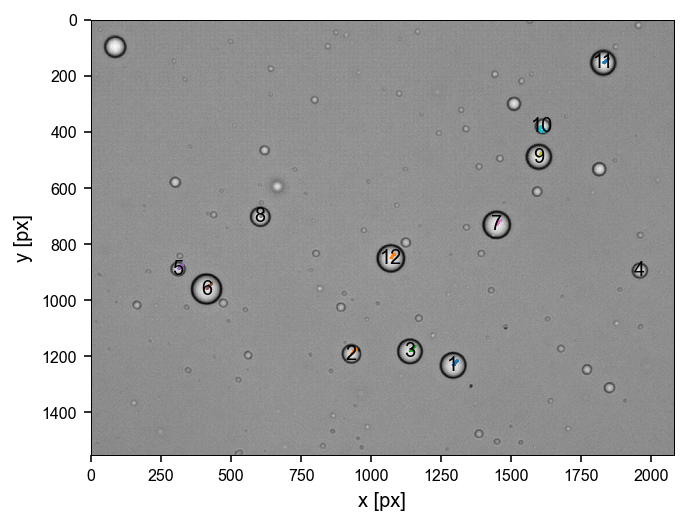

In [257]:
ax = tp.plot_traj(linked_droplets, label=True, superimpose=imgs[0])

In [258]:
linked_droplets.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
12,1231.962659,1291.038251,1.219390,0.883465,0.284714,0.267644,1.221296,NaN,0,1
11,1190.961816,928.982456,1.076128,0.885615,0.277632,0.232106,1.078090,NaN,0,2
10,1181.987058,1137.963762,1.287133,0.883655,0.279558,0.282081,1.290364,NaN,0,3
8,893.970414,1957.976331,0.187684,0.880425,0.297710,0.042201,0.191069,NaN,0,4
7,887.975410,310.967213,0.135488,0.873095,0.301075,0.032206,0.138347,NaN,0,5


In [259]:
#ipart = 87
#idx = (linked_droplets['particle']==ipart)

#plt.imshow(imgs[16], cmap='gray')
#plt.plot(linked_droplets[idx]['x'].values, linked_droplets[idx]['y'].values, 'r');

In [260]:
linked_droplets.to_csv('23.11.21 drop_radius_knots v7 for 24.07.08 linked drops (24.07.08 f02 0 to 2080).csv')

# Radius calculation

In [261]:
#df1 = pd.read_excel('Book3.xlsx',index_col=0, names=['r_samp','intensity'])
#df1.head()

In [262]:
def calc_drop_size3(img, row, wsize, theta = 1, sigma = 5):
    # identify drop
    yc = int(np.round(row['y'])) # drop center pixel accuracy
    xc = int(np.round(row['x'])) 
    dy = row['y'] - yc
    dx = row['x'] - xc
    
    if (yc - wsize < 0) or (yc + wsize + 1 >= ysize) or (xc - wsize < 0) or (xc + wsize + 1 >= xsize):
        return np.nan
    
    # make a window
    yw = np.arange(-wsize, wsize + 1) - dy
    xw = np.arange(-wsize, wsize + 1) - dx
    rw = np.ndarray.flatten(np.sqrt(yw[:, None]**2 + xw[None, :]**2))
    iw = np.ndarray.flatten(img[yc - wsize:yc + wsize + 1, xc - wsize:xc + wsize + 1])
    
    num_of_knots = 30
    knot_positions = np.linspace(3, wsize, num_of_knots)

    # Performe the spline fitting (degree=k)
    isort = np.argsort(rw)
    spline = LSQUnivariateSpline(rw[isort], iw[isort], knot_positions, k=5)

    # Calculate second derivative at multiple points
    r_eval = np.linspace(3, wsize, 1000)  # Evaluate over the entire range
    spline_second_derivative = spline.derivative(2)
    second_derivative_values = spline_second_derivative(r_eval)

    # Find sign changes in the second derivative
    sign_changes = np.where(np.diff(np.sign(second_derivative_values)))[0]

    # Calculate the derivative of the spline at the inflection points
    inflection_points = r_eval[sign_changes]
    spline_derivative_values = spline.derivative()(inflection_points)

    # Find the inflection point with the maximum positive slope
    max_positive_slope_index = np.argmax(spline_derivative_values)
    rmax2 = inflection_points[max_positive_slope_index]
    imax2 = spline(rmax2)
    
    radius = rmax2
        
    return radius

# radius calc using changing wsize

In [263]:
# Convert 'frame' column to integers in final_droplets DataFrame
linked_droplets['frame'] = linked_droplets['frame'].astype(int)

# Iterate through each unique particle
for particle in linked_droplets['particle'].unique():
    idx = (linked_droplets['particle'] == particle)
    print('particle=', particle)
    
    # Iterate through the rows for the current particle
    for index, row in linked_droplets[idx].iterrows():
        # Ensure the 'frame' value is an integer
        frame_index = int(row['frame'])
        print('frame = ', frame_index)
        wsize = 120
            
        #checkpoint
            
        if frame_index > 1:
            frame_2 = frame_index - 1
            index_2 = (linked_droplets['particle']==particle) & (linked_droplets['frame']==frame_2)
            #radius of particle in the previous frame
            radius_2 = linked_droplets[index_2]['radius'].values
            checkpoint = (wsize - 1)/pixel_per_micron
            if radius_2 > checkpoint:
                wsize = 150  
                print('changed wsize', wsize)
            
        radius = calc_drop_size3(imgs[frame_index], row, wsize)

        # Check for NaN values in the radius calculation
        if not np.isnan(radius):
            # Convert radius to microns
            pixel_per_micron = 6.76
            radius_microns = radius / pixel_per_micron

            # Update 'radius' column for the current row
            linked_droplets.at[index, 'radius'] = radius_microns

            # Print progress
            print(f"Particle {particle}, Radius: {radius_microns}")

# Check the resulting DataFrame with updated radius values
print(linked_droplets.head())



particle= 1
frame =  0
Particle 1, Radius: 7.096593635055173
frame =  1
Particle 1, Radius: 7.079268617730157
frame =  2
Particle 1, Radius: 7.096593635055173
frame =  3
Particle 1, Radius: 7.079268617730157
frame =  4
Particle 1, Radius: 7.096593635055173
frame =  5
Particle 1, Radius: 7.096593635055173
frame =  6
Particle 1, Radius: 7.079268617730157
frame =  7
Particle 1, Radius: 7.096593635055173
frame =  8
Particle 1, Radius: 7.079268617730157
frame =  9
Particle 1, Radius: 7.096593635055173
frame =  10
Particle 1, Radius: 7.096593635055173
frame =  11
Particle 1, Radius: 7.079268617730157
frame =  12
Particle 1, Radius: 7.096593635055173
frame =  13
Particle 1, Radius: 7.096593635055173
frame =  14
Particle 1, Radius: 7.079268617730157
frame =  15
Particle 1, Radius: 7.079268617730157
frame =  16
Particle 1, Radius: 7.079268617730157
frame =  17
Particle 1, Radius: 7.061943600405139
frame =  18
Particle 1, Radius: 7.079268617730157
frame =  19
Particle 1, Radius: 7.06194360040513

Particle 2, Radius: 5.104216642678181
frame =  65
Particle 2, Radius: 5.121541660003198
frame =  66
Particle 2, Radius: 5.104216642678181
frame =  67
Particle 2, Radius: 5.121541660003198
frame =  68
Particle 2, Radius: 5.121541660003198
frame =  69
Particle 2, Radius: 5.104216642678181
frame =  70
Particle 2, Radius: 5.121541660003198
frame =  71
Particle 2, Radius: 5.138866677328216
frame =  72
Particle 2, Radius: 5.1561916946532325
frame =  73
Particle 2, Radius: 5.17351671197825
frame =  74
Particle 2, Radius: 5.208166746628285
frame =  75
Particle 2, Radius: 5.208166746628285
frame =  76
Particle 2, Radius: 5.24281678127832
frame =  77
Particle 2, Radius: 5.277466815928355
frame =  78
Particle 2, Radius: 5.329441867903406
frame =  79
Particle 2, Radius: 5.3814169198784585
frame =  80
Particle 2, Radius: 5.450716989178527
frame =  81
Particle 2, Radius: 5.520017058478597
frame =  82
Particle 2, Radius: 5.589317127778666
frame =  83
Particle 2, Radius: 5.675942214403753
frame =  84


Particle 5, Radius: 4.030065568527107
frame =  36
Particle 5, Radius: 4.030065568527107
frame =  37
Particle 5, Radius: 4.030065568527107
frame =  38
Particle 5, Radius: 4.047390585852124
frame =  39
Particle 5, Radius: 4.030065568527107
frame =  40
Particle 5, Radius: 4.012740551202089
frame =  41
Particle 5, Radius: 4.012740551202089
frame =  42
Particle 5, Radius: 4.012740551202089
frame =  43
Particle 5, Radius: 3.9954155338770727
frame =  44
Particle 5, Radius: 4.012740551202089
frame =  45
Particle 5, Radius: 4.012740551202089
frame =  46
Particle 5, Radius: 3.9954155338770727
frame =  47
Particle 5, Radius: 3.9954155338770727
frame =  48
Particle 5, Radius: 3.9954155338770727
frame =  49
Particle 5, Radius: 4.012740551202089
frame =  50
Particle 5, Radius: 3.9780905165520553
frame =  51
Particle 5, Radius: 3.9780905165520553
frame =  52
Particle 5, Radius: 3.9954155338770727
frame =  53
Particle 5, Radius: 3.9780905165520553
frame =  54
Particle 5, Radius: 3.9780905165520553
fra

Particle 7, Radius: 7.5123940508555895
frame =  10
Particle 7, Radius: 7.5123940508555895
frame =  11
Particle 7, Radius: 7.5123940508555895
frame =  12
Particle 7, Radius: 7.5123940508555895
frame =  13
Particle 7, Radius: 7.5123940508555895
frame =  14
Particle 7, Radius: 7.5123940508555895
frame =  15
Particle 7, Radius: 7.529719068180607
frame =  16
Particle 7, Radius: 7.5123940508555895
frame =  17
Particle 7, Radius: 7.529719068180607
frame =  18
Particle 7, Radius: 7.5123940508555895
frame =  19
Particle 7, Radius: 7.529719068180607
frame =  20
Particle 7, Radius: 7.5123940508555895
frame =  21
Particle 7, Radius: 7.5123940508555895
frame =  22
Particle 7, Radius: 7.5123940508555895
frame =  23
Particle 7, Radius: 7.5123940508555895
frame =  24
Particle 7, Radius: 7.5123940508555895
frame =  25
Particle 7, Radius: 7.5123940508555895
frame =  26
Particle 7, Radius: 7.495069033530572
frame =  27
Particle 7, Radius: 7.495069033530572
frame =  28
Particle 7, Radius: 7.49506903353057

Particle 8, Radius: 5.6412921797537185
frame =  79
Particle 8, Radius: 5.7105922490537875
frame =  80
Particle 8, Radius: 5.779892318353856
frame =  81
Particle 8, Radius: 5.918492456953995
frame =  82
Particle 8, Radius: 6.057092595554134
frame =  83
Particle 8, Radius: 6.178367716829255
frame =  84
Particle 8, Radius: 6.282317820779359
frame =  85
Particle 8, Radius: 6.438242976704515
frame =  86
Particle 8, Radius: 6.5941681326296715
frame =  87
Particle 8, Radius: 6.698118236579775
frame =  88
Particle 8, Radius: 6.767418305879844
frame =  89
Particle 8, Radius: 6.819393357854897
frame =  90
Particle 8, Radius: 6.8540433925049316
frame =  91
Particle 8, Radius: 6.906018444479983
frame =  92
Particle 8, Radius: 6.975318513780053
frame =  93
Particle 8, Radius: 7.044618583080122
frame =  94
Particle 8, Radius: 7.148568687030226
frame =  95
Particle 8, Radius: 7.235193773655312
frame =  96
Particle 8, Radius: 7.321818860280399
frame =  97
Particle 8, Radius: 7.391118929580468
frame = 

/var/folders/qc/83gs3ttd5wx5s2rvcr3tmswm0000gn/T/ipykernel_88634/3257515042.py:24: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if radius_2 > checkpoint:


Particle 10, Radius: 4.220640759102298
frame =  24
Particle 10, Radius: 4.220640759102298
frame =  25
Particle 10, Radius: 4.220640759102298
frame =  26
Particle 10, Radius: 4.20331574177728
frame =  27
Particle 10, Radius: 4.20331574177728
frame =  28
Particle 10, Radius: 4.20331574177728
frame =  29
Particle 10, Radius: 4.20331574177728
frame =  30
Particle 10, Radius: 4.185990724452263
frame =  31
Particle 10, Radius: 4.20331574177728
frame =  32
Particle 10, Radius: 4.20331574177728
frame =  33
Particle 10, Radius: 4.20331574177728
frame =  34
Particle 10, Radius: 4.20331574177728
frame =  35
Particle 10, Radius: 4.185990724452263
frame =  36
Particle 10, Radius: 4.185990724452263
frame =  37
Particle 10, Radius: 4.185990724452263
frame =  38
Particle 10, Radius: 4.185990724452263
frame =  39
Particle 10, Radius: 4.185990724452263
frame =  40
Particle 10, Radius: 4.185990724452263
frame =  41
Particle 10, Radius: 4.185990724452263
frame =  42
Particle 10, Radius: 4.185990724452263


Particle 12, Radius: 7.5123940508555895
frame =  1
Particle 12, Radius: 7.5123940508555895
frame =  2
Particle 12, Radius: 7.529719068180607
frame =  3
Particle 12, Radius: 7.529719068180607
frame =  4
Particle 12, Radius: 7.5123940508555895
frame =  5
Particle 12, Radius: 7.5123940508555895
frame =  6
Particle 12, Radius: 7.5123940508555895
frame =  7
Particle 12, Radius: 7.529719068180607
frame =  8
Particle 12, Radius: 7.529719068180607
frame =  9
Particle 12, Radius: 7.529719068180607
frame =  10
Particle 12, Radius: 7.5123940508555895
frame =  11
Particle 12, Radius: 7.5123940508555895
frame =  12
Particle 12, Radius: 7.5123940508555895
frame =  13
Particle 12, Radius: 7.5123940508555895
frame =  14
Particle 12, Radius: 7.495069033530572
frame =  15
Particle 12, Radius: 7.5123940508555895
frame =  16
Particle 12, Radius: 7.5123940508555895
frame =  17
Particle 12, Radius: 7.5123940508555895
frame =  18
Particle 12, Radius: 7.5123940508555895
frame =  19
Particle 12, Radius: 7.5123

In [264]:
linked_droplets.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,radius
12,1231.962659,1291.038251,1.219390,0.883465,0.284714,0.267644,1.221296,NaN,0,1,7.096594
11,1190.961816,928.982456,1.076128,0.885615,0.277632,0.232106,1.078090,NaN,0,2,5.190842
10,1181.987058,1137.963762,1.287133,0.883655,0.279558,0.282081,1.290364,NaN,0,3,6.784743
8,893.970414,1957.976331,0.187684,0.880425,0.297710,0.042201,0.191069,NaN,0,4,4.324591
7,887.975410,310.967213,0.135488,0.873095,0.301075,0.032206,0.138347,NaN,0,5,4.082041


In [265]:
linked_droplets.to_csv('23.11.21 drop_radius_knots v7 for 24.07.08 linked drops (24.07.08 f02 0 to 2080).csv')

# plot radius of all particles

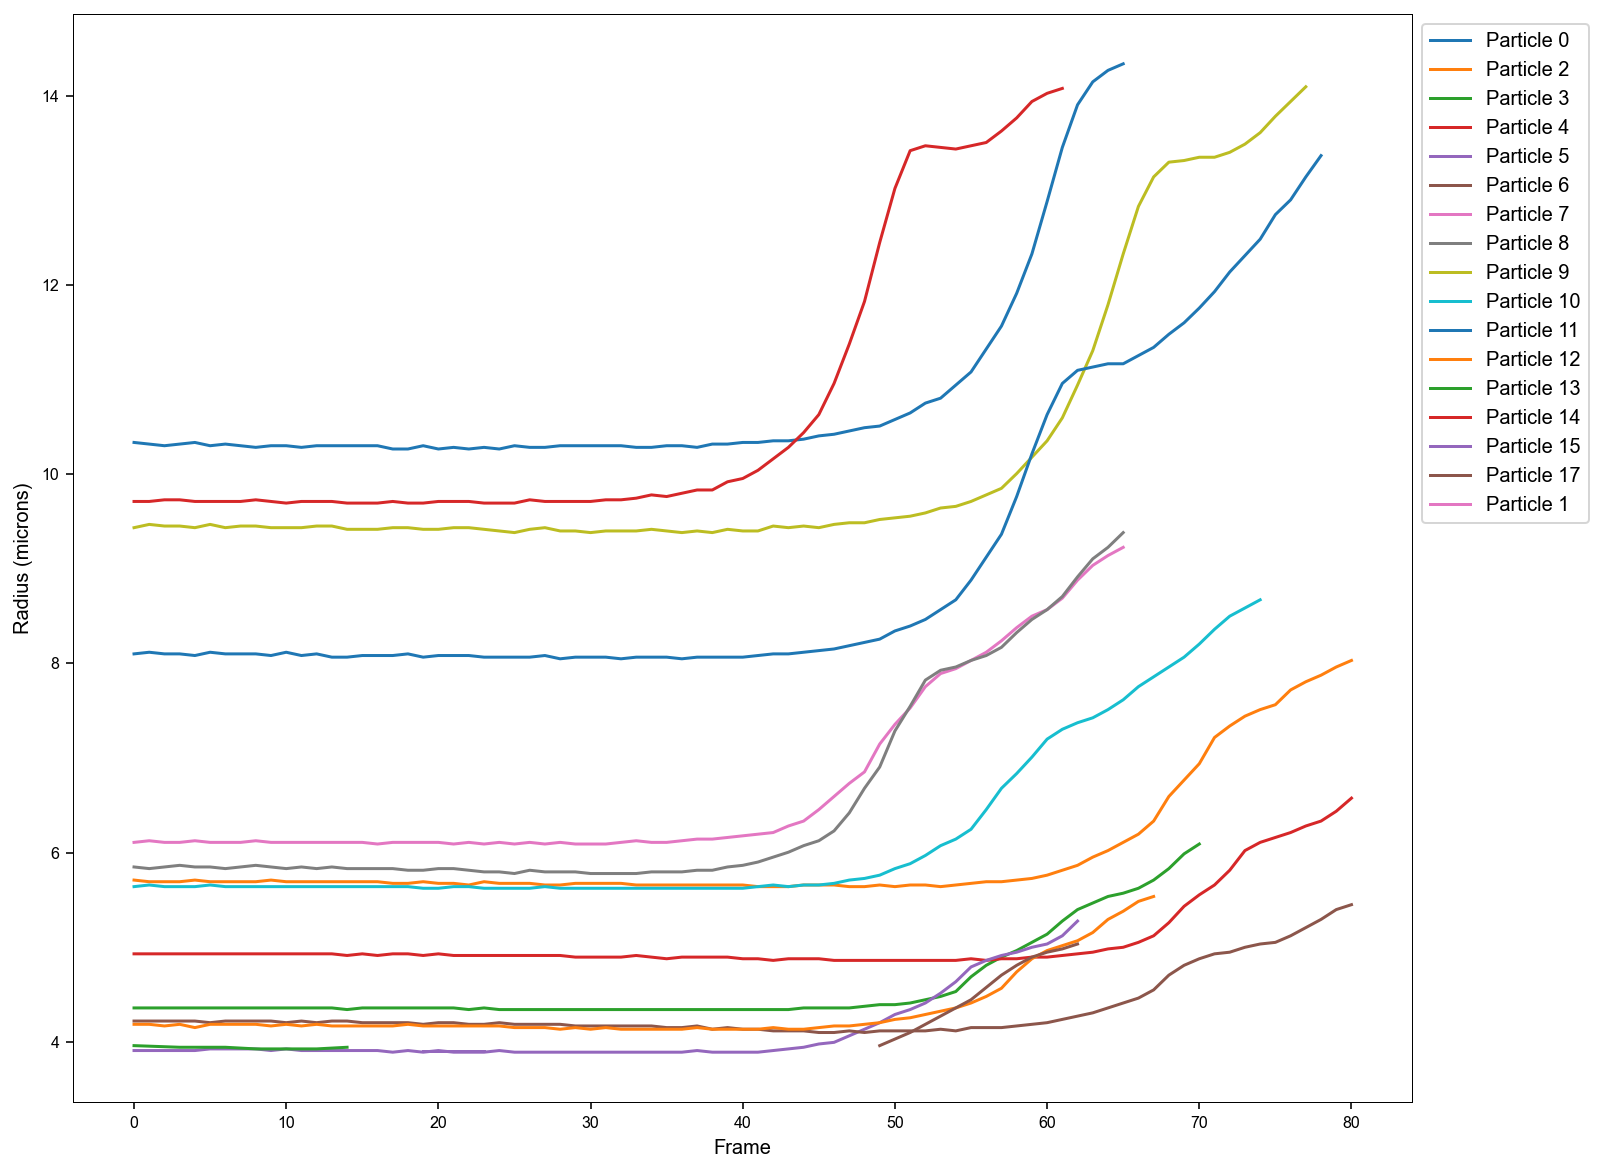

In [207]:
# Create a new figure
plt.figure(figsize=(12, 10))

# Iterate through each unique particle
for particle in linked_droplets['particle'].unique():
    # Create a mask to select rows for the current particle
    mask = linked_droplets['particle'] == particle

    # Extract the data for the current particle
    data = linked_droplets[mask]

    # Plot the radius over frames for the current particle on the same graph
    plt.plot(data['frame'], data['radius'], '-', label=f'Particle {particle}')
plt.xlabel('Frame')
plt.ylabel('Radius (microns)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.ylim(1.5,3)

plt.show()

# plot radius of any single particle if required

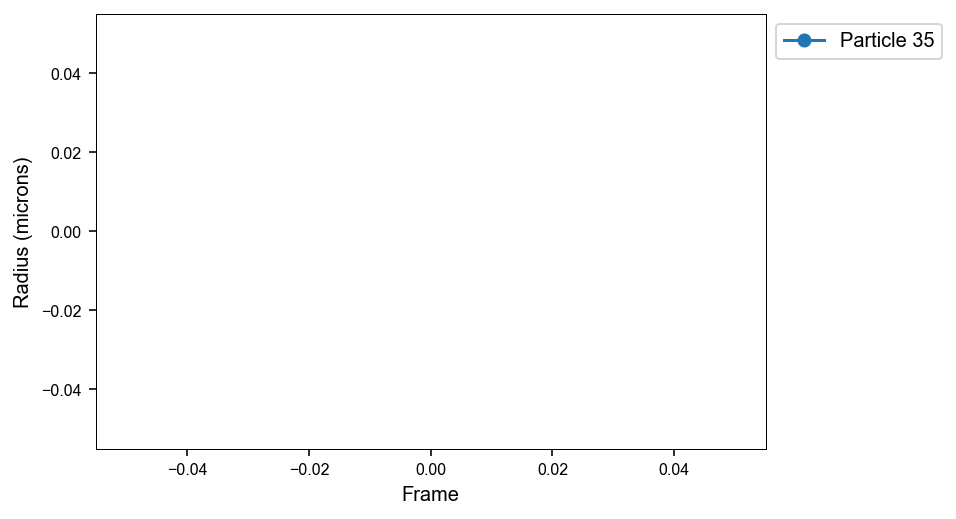

In [153]:
# Create a new figure
plt.figure()
#plt.xlim(465,483)
particle = 14
mask = linked_droplets['particle'] == particle
data = linked_droplets[mask]
plt.plot(data['frame'], data['radius'], '-o', label=f'Particle {particle}')
plt.xlabel('Frame')
plt.ylabel('Radius (microns)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

# only consider the particles that appear in frame 0

In [267]:
particles_in_frame_0 = linked_droplets[linked_droplets['frame'] == 0]['particle'].unique()
final_droplets = linked_droplets[linked_droplets['particle'].isin(particles_in_frame_0)]

In [268]:
# group the data by particle ID and count the number of frames each particle appears in after filtering
frame0_counts = final_droplets.groupby('particle')['frame'].nunique()
frame0counts = pd.DataFrame(frame0_counts)
frame0counts.head()
#frame0counts.to_csv('frame0counts (11.14-15 exp trial 3 f09 0-999).csv')

,frame
particle,
1,100
2,100
3,100
4,1
5,93


In [269]:
## filter the droplets that dont appear in a minimum nuber of frames
#filtered_droplets = frame_counts[frame_counts >= 200].index
#final_droplets = linked_droplets[linked_droplets['particle'].isin(filtered_droplets)]

In [270]:
final_droplets

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,radius
12,1231.962659,1291.038251,1.219390,0.883465,0.284714,0.267644,1.221296,NaN,0,1,7.096594
11,1190.961816,928.982456,1.076128,0.885615,0.277632,0.232106,1.078090,NaN,0,2,5.190842
10,1181.987058,1137.963762,1.287133,0.883655,0.279558,0.282081,1.290364,NaN,0,3,6.784743
8,893.970414,1957.976331,0.187684,0.880425,0.297710,0.042201,0.191069,NaN,0,4,4.324591
7,887.975410,310.967213,0.135488,0.873095,0.301075,0.032206,0.138347,NaN,0,5,4.082041
...,...,...,...,...,...,...,...,...,...,...,...
1274,679.041379,618.024138,0.176726,0.872966,0.316742,0.042049,0.178400,NaN,99,8,7.564369
1275,716.988999,1462.017602,0.553946,0.883786,0.288732,0.121271,0.555112,NaN,99,7,10.301722
1276,838.988166,1085.970414,0.308966,0.882662,0.281013,0.068253,0.309810,NaN,99,12,10.648222
1278,1164.010568,1157.976222,0.461317,0.887310,0.283557,0.098114,0.462726,NaN,99,3,9.487446


# plot radius vs frame for drops present in frame 0

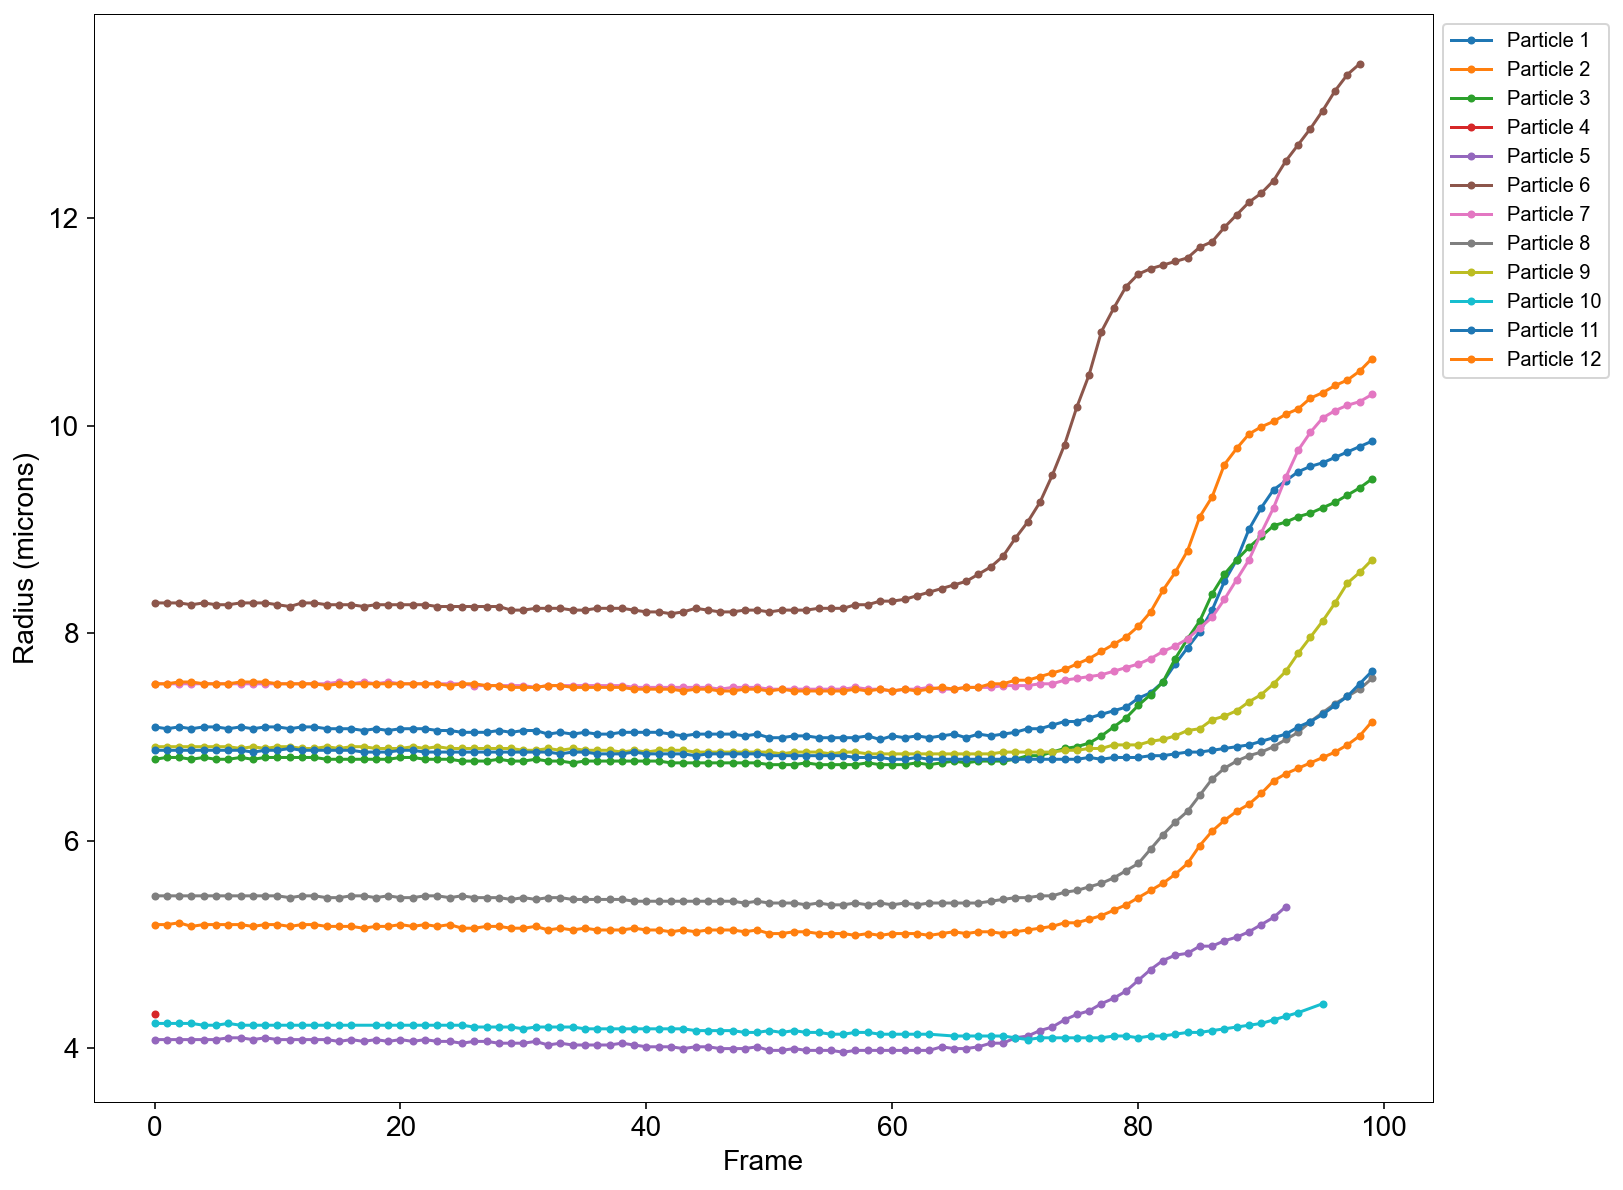

In [271]:
# Create a new figure
plt.figure(figsize=(12, 10))

# Iterate through each unique particle
for particle in final_droplets['particle'].unique():
    # Create a mask to select rows for the current particle
    mask = final_droplets['particle'] == particle

    # Extract the data for the current particle
    data = final_droplets[mask]

    # Plot the radius over frames for the current particle on the same graph
    plt.plot(data['frame'], data['radius'], '.-', label=f'Particle {particle}')
    
plt.xlabel('Frame', fontsize = 14)
plt.ylabel('Radius (microns)', fontsize = 14)
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.show()

In [272]:
final_droplets.to_csv('23.11.21 drop_radius_knots v7 for 24.07.08_radius after filtering (24.07.08 f02 0 to 2080) v2.csv')

# check radius over time of any single drop if required

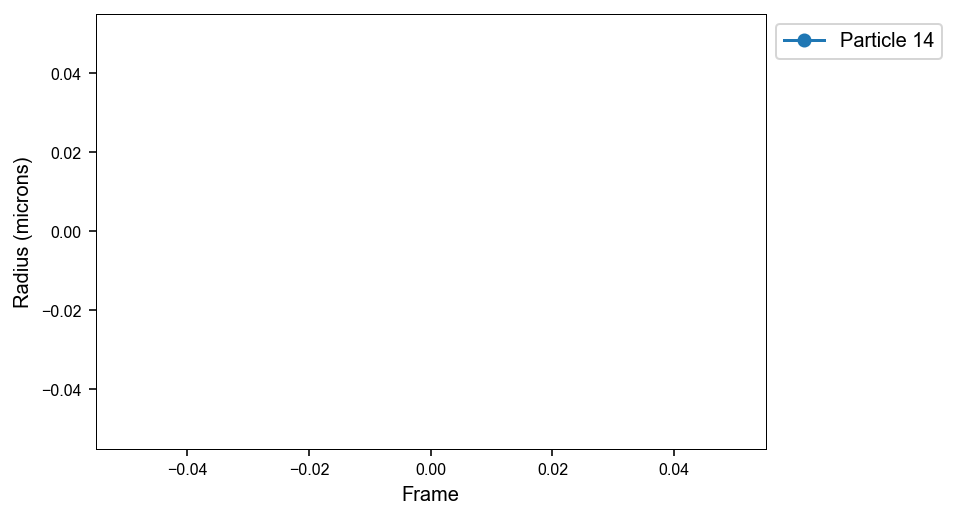

In [192]:
# Create a new figure
plt.figure()

particle = 14
mask = final_droplets['particle'] == particle
data = final_droplets[mask]
plt.plot(data['frame'], data['radius'], '-o', label=f'Particle {particle}')
plt.xlabel('Frame')
plt.ylabel('Radius (microns)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [172]:
# Create a new figure
#plt.figure()

#particle = 0
#mask = final_droplets['particle'] == particle
#data = final_droplets[mask]
#plt.plot(data['frame'], data['mass'], '-o', label=f'Particle {particle}')
#plt.xlabel('Frame')
#plt.ylabel('Radius (microns)')
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

#plt.show()

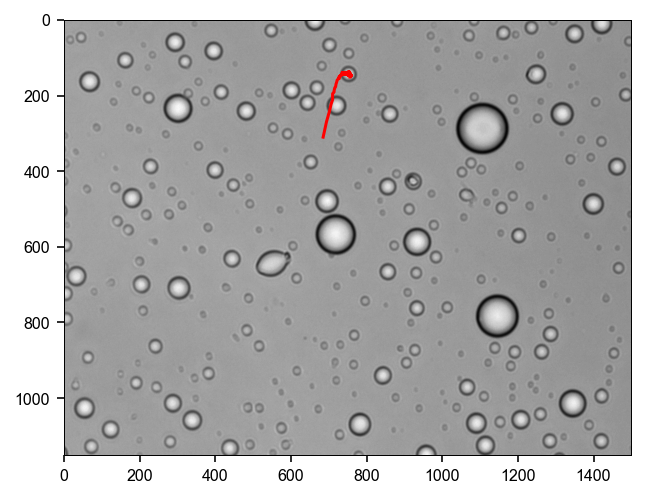

In [172]:
ipart =  31
idx = (final_droplets['particle']==ipart)

plt.imshow(imgs[234], cmap='gray')
plt.plot(final_droplets[idx]['x'].values, final_droplets[idx]['y'].values, 'r');

# signal and vacoule detection

In [273]:
final_droplets = pd.read_csv('23.11.21 drop_radius_knots v7 for 24.07.08_radius after filtering (24.07.08 f02 0 to 2080) v2.csv')

In [274]:
final_droplets.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,radius
0,12,1231.962659,1291.038251,1.219390,0.883465,0.284714,0.267644,1.221296,NaN,0,1,7.096594
1,11,1190.961816,928.982456,1.076128,0.885615,0.277632,0.232106,1.078090,NaN,0,2,5.190842
2,10,1181.987058,1137.963762,1.287133,0.883655,0.279558,0.282081,1.290364,NaN,0,3,6.784743
3,8,893.970414,1957.976331,0.187684,0.880425,0.297710,0.042201,0.191069,NaN,0,4,4.324591
4,7,887.975410,310.967213,0.135488,0.873095,0.301075,0.032206,0.138347,NaN,0,5,4.082041


In [275]:
start = 0
stop = 99
frame_nos = np.arange(start, stop + 1)

all_vsignals = []

particles = final_droplets['particle'].unique()

for particle in particles:
    vsignals = []  # initialize the signals list for the current particle
    print("Processing particle:", particle)
    
    for frame in frame_nos:
        #frame_v2 = frame + 500
        idx = (final_droplets['frame'] == frame) & (final_droplets['particle'] == particle)
        img = frames[frame][ymin:ymin + ysize, xmin:xmin + xsize]
        radius = final_droplets[idx]['radius'].values * 6.76
        if not len(radius) == 0:                                                                      
            print("Processing frame:", frame)

            wsize = radius * 1.2
            wsize = int(wsize)

            yc = final_droplets['y'].values[idx]
            xc = final_droplets['x'].values[idx]

            ycPix = int(yc)
            xcPix = int(xc)

            xPix = np.arange(-wsize, wsize)
            yPix = np.arange(-wsize, wsize + 1)
            rPix = np.sqrt((xPix[:, None] + xc - xcPix) ** 2 + (yPix[None, :] + yc - ycPix) ** 2)
            thetaPix = np.arctan2(yPix[None, :] + yc - ycPix, xPix[:, None] + xc - xcPix)

            rMax = int(wsize / np.sqrt(2)) # rMax is 85% of the radius
            rBins = np.arange(2, rMax + 1)
            means = np.zeros((rMax - 1,))
            variances = np.zeros((rMax - 1,))
            counts = np.zeros((rMax - 1,))
            params = np.zeros((rMax - 1, 7))
            cropped = img[ycPix - wsize:ycPix + wsize, xcPix - wsize:xcPix + wsize + 1]
                
            for i, r in enumerate(rBins):
                index = (rPix > r) & (rPix < r + 1) # concentric circle
                intensities = np.array(cropped[index])

                # calculate variances and means
                counts[i] = intensities.shape[0]
                means[i] = np.mean(intensities)
                variances[i] = np.var(intensities)

                # fit harmonic functions
                X = np.column_stack((thetaPix[index] ** 0, np.cos(thetaPix[index]), np.sin(thetaPix[index]),
                                    np.cos(2 * thetaPix[index]), np.sin(2 * thetaPix[index]),
                                    np.cos(3 * thetaPix[index]), np.sin(3 * thetaPix[index])))
                params[i, :] = np.linalg.lstsq(X, intensities, rcond=None)[0]

            vsignal = np.sum(counts * (params[:, 5] ** 2 + params[:, 6] ** 2) / np.sqrt(np.pi)) / np.sum(counts)
            #all_vsignals.append(vsignal)
            final_droplets.loc[idx, 'vsignal'] = vsignal
            print('visgnal=', radius)
        #else:
            #vsignals.append(np.nan)
    #final_droplets.loc[idx, 'vsignal'] = np.nan
            
    print(f"Particle {particle}, Frame {frame}: Signal = {vsignal}")

#final_droplets.loc[idx,'vsignal'] = all_vsignals
#final_droplets.loc[final_droplets['particle'] == particle, 'vsignal'] = vsignals

Processing particle: 1
Processing frame: 0
visgnal= [47.97297297]
Processing frame: 1
visgnal= [47.85585586]
Processing frame: 2
visgnal= [47.97297297]
Processing frame: 3
visgnal= [47.85585586]
Processing frame: 4
visgnal= [47.97297297]
Processing frame: 5
visgnal= [47.97297297]
Processing frame: 6
visgnal= [47.85585586]
Processing frame: 7
visgnal= [47.97297297]
Processing frame: 8
visgnal= [47.85585586]
Processing frame: 9
visgnal= [47.97297297]
Processing frame: 10
visgnal= [47.97297297]
Processing frame: 11
visgnal= [47.85585586]
Processing frame: 12
visgnal= [47.97297297]
Processing frame: 13
visgnal= [47.97297297]
Processing frame: 14
visgnal= [47.85585586]
Processing frame: 15
visgnal= [47.85585586]
Processing frame: 16
visgnal= [47.85585586]
Processing frame: 17
visgnal= [47.73873874]
Processing frame: 18
visgnal= [47.85585586]
Processing frame: 19
visgnal= [47.73873874]
Processing frame: 20
visgnal= [47.85585586]
Processing frame: 21
visgnal= [47.85585586]
Processing frame: 2

Processing frame: 88
visgnal= [42.46846847]
Processing frame: 89
visgnal= [42.93693694]
Processing frame: 90
visgnal= [43.63963964]
Processing frame: 91
visgnal= [44.45945946]
Processing frame: 92
visgnal= [44.92792793]
Processing frame: 93
visgnal= [45.27927928]
Processing frame: 94
visgnal= [45.63063063]
Processing frame: 95
visgnal= [45.98198198]
Processing frame: 96
visgnal= [46.33333333]
Processing frame: 97
visgnal= [46.8018018]
Processing frame: 98
visgnal= [47.38738739]
Processing frame: 99
visgnal= [48.32432432]
Particle 2, Frame 99: Signal = 2.9742963053999265
Processing particle: 3
Processing frame: 0
visgnal= [45.86486486]
Processing frame: 1
visgnal= [45.98198198]
Processing frame: 2
visgnal= [45.98198198]
Processing frame: 3
visgnal= [45.86486486]
Processing frame: 4
visgnal= [45.98198198]
Processing frame: 5
visgnal= [45.86486486]
Processing frame: 6
visgnal= [45.86486486]
Processing frame: 7
visgnal= [45.98198198]
Processing frame: 8
visgnal= [45.86486486]
Processing fr

visgnal= [27.36036036]
Processing frame: 70
visgnal= [27.71171171]
Processing frame: 71
visgnal= [27.82882883]
Processing frame: 72
visgnal= [28.18018018]
Processing frame: 73
visgnal= [28.41441441]
Processing frame: 74
visgnal= [28.88288288]
Processing frame: 75
visgnal= [29.23423423]
Processing frame: 76
visgnal= [29.46846847]
Processing frame: 77
visgnal= [29.93693694]
Processing frame: 78
visgnal= [30.28828829]
Processing frame: 79
visgnal= [30.75675676]
Processing frame: 80
visgnal= [31.45945946]
Processing frame: 81
visgnal= [32.16216216]
Processing frame: 82
visgnal= [32.74774775]
Processing frame: 83
visgnal= [33.0990991]
Processing frame: 84
visgnal= [33.21621622]
Processing frame: 85
visgnal= [33.68468468]
Processing frame: 86
visgnal= [33.68468468]
Processing frame: 87
visgnal= [34.03603604]
Processing frame: 88
visgnal= [34.27027027]
Processing frame: 89
visgnal= [34.62162162]
Processing frame: 90
visgnal= [35.09009009]
Processing frame: 91
visgnal= [35.55855856]
Processing

Processing frame: 62
visgnal= [50.43243243]
Processing frame: 63
visgnal= [50.54954955]
Processing frame: 64
visgnal= [50.43243243]
Processing frame: 65
visgnal= [50.43243243]
Processing frame: 66
visgnal= [50.54954955]
Processing frame: 67
visgnal= [50.54954955]
Processing frame: 68
visgnal= [50.54954955]
Processing frame: 69
visgnal= [50.66666667]
Processing frame: 70
visgnal= [50.66666667]
Processing frame: 71
visgnal= [50.66666667]
Processing frame: 72
visgnal= [50.78378378]
Processing frame: 73
visgnal= [50.78378378]
Processing frame: 74
visgnal= [51.01801802]
Processing frame: 75
visgnal= [51.13513514]
Processing frame: 76
visgnal= [51.25225225]
Processing frame: 77
visgnal= [51.36936937]
Processing frame: 78
visgnal= [51.6036036]
Processing frame: 79
visgnal= [51.83783784]
Processing frame: 80
visgnal= [52.07207207]
Processing frame: 81
visgnal= [52.42342342]
Processing frame: 82
visgnal= [52.89189189]
Processing frame: 83
visgnal= [53.24324324]
Processing frame: 84
visgnal= [53

Processing frame: 46
visgnal= [46.33333333]
Processing frame: 47
visgnal= [46.33333333]
Processing frame: 48
visgnal= [46.33333333]
Processing frame: 49
visgnal= [46.33333333]
Processing frame: 50
visgnal= [46.33333333]
Processing frame: 51
visgnal= [46.21621622]
Processing frame: 52
visgnal= [46.33333333]
Processing frame: 53
visgnal= [46.33333333]
Processing frame: 54
visgnal= [46.33333333]
Processing frame: 55
visgnal= [46.21621622]
Processing frame: 56
visgnal= [46.33333333]
Processing frame: 57
visgnal= [46.33333333]
Processing frame: 58
visgnal= [46.21621622]
Processing frame: 59
visgnal= [46.21621622]
Processing frame: 60
visgnal= [46.21621622]
Processing frame: 61
visgnal= [46.21621622]
Processing frame: 62
visgnal= [46.21621622]
Processing frame: 63
visgnal= [46.21621622]
Processing frame: 64
visgnal= [46.21621622]
Processing frame: 65
visgnal= [46.21621622]
Processing frame: 66
visgnal= [46.21621622]
Processing frame: 67
visgnal= [46.21621622]
Processing frame: 68
visgnal= [4

visgnal= [46.21621622]
Processing frame: 38
visgnal= [46.21621622]
Processing frame: 39
visgnal= [46.33333333]
Processing frame: 40
visgnal= [46.21621622]
Processing frame: 41
visgnal= [46.21621622]
Processing frame: 42
visgnal= [46.21621622]
Processing frame: 43
visgnal= [46.21621622]
Processing frame: 44
visgnal= [46.0990991]
Processing frame: 45
visgnal= [46.21621622]
Processing frame: 46
visgnal= [46.21621622]
Processing frame: 47
visgnal= [46.21621622]
Processing frame: 48
visgnal= [46.21621622]
Processing frame: 49
visgnal= [46.21621622]
Processing frame: 50
visgnal= [46.0990991]
Processing frame: 51
visgnal= [46.0990991]
Processing frame: 52
visgnal= [46.0990991]
Processing frame: 53
visgnal= [46.0990991]
Processing frame: 54
visgnal= [46.0990991]
Processing frame: 55
visgnal= [46.0990991]
Processing frame: 56
visgnal= [46.0990991]
Processing frame: 57
visgnal= [45.98198198]
Processing frame: 58
visgnal= [45.98198198]
Processing frame: 59
visgnal= [45.98198198]
Processing frame:

In [276]:
final_droplets

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,radius,vsignal
0,12,1231.962659,1291.038251,1.219390,0.883465,0.284714,0.267644,1.221296,NaN,0,1,7.096594,0.120669
1,11,1190.961816,928.982456,1.076128,0.885615,0.277632,0.232106,1.078090,NaN,0,2,5.190842,0.520022
2,10,1181.987058,1137.963762,1.287133,0.883655,0.279558,0.282081,1.290364,NaN,0,3,6.784743,0.171886
3,8,893.970414,1957.976331,0.187684,0.880425,0.297710,0.042201,0.191069,NaN,0,4,4.324591,0.181317
4,7,887.975410,310.967213,0.135488,0.873095,0.301075,0.032206,0.138347,NaN,0,5,4.082041,0.252257
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,1274,679.041379,618.024138,0.176726,0.872966,0.316742,0.042049,0.178400,NaN,99,8,7.564369,1.238025
1082,1275,716.988999,1462.017602,0.553946,0.883786,0.288732,0.121271,0.555112,NaN,99,7,10.301722,4.769989
1083,1276,838.988166,1085.970414,0.308966,0.882662,0.281013,0.068253,0.309810,NaN,99,12,10.648222,0.735068
1084,1278,1164.010568,1157.976222,0.461317,0.887310,0.283557,0.098114,0.462726,NaN,99,3,9.487446,1.198587


## plot vsignal of all drops

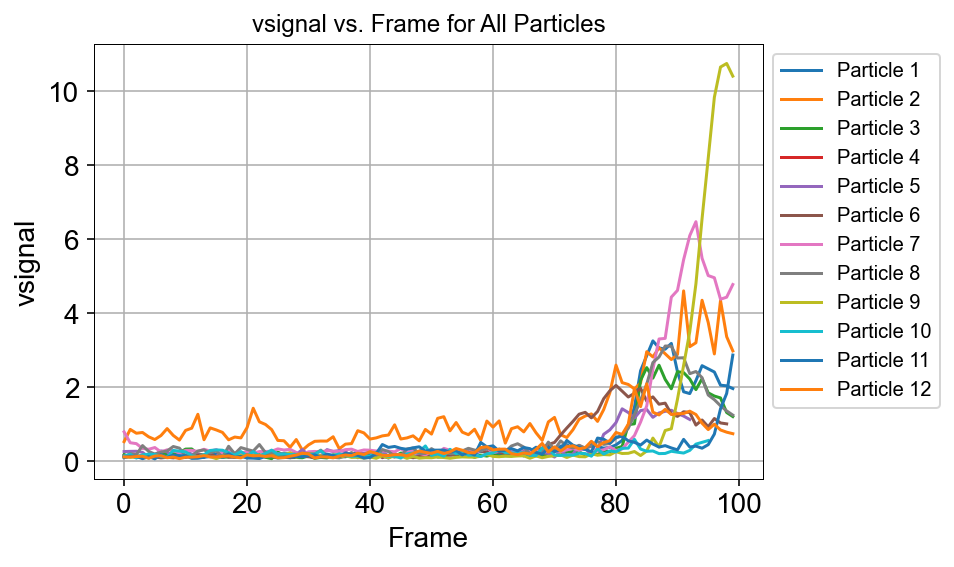

In [277]:
particles = final_droplets['particle'].unique()

plt.figure()  
plt.title('vsignal vs. Frame for All Particles')
plt.xlabel('Frame')
plt.ylabel('vsignal')
#plt.ylim(0,1.4)

for particle in particles:
    index_radius = (final_droplets['particle']==particle) & (final_droplets['frame']==0)
    radius_ini = final_droplets[index_radius]['radius'].values
    if radius_ini > 3.2:
        particle_data = final_droplets[final_droplets['particle'] == particle]
        plt.plot(particle_data['frame'], particle_data['vsignal'], label=f'Particle {particle}')

        
plt.xlabel('Frame', fontsize = 14)
plt.ylabel('vsignal', fontsize = 14)
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)            

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
#plt.ylim(0,1.5)
plt.show()


## plot vsignal of a single drop

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

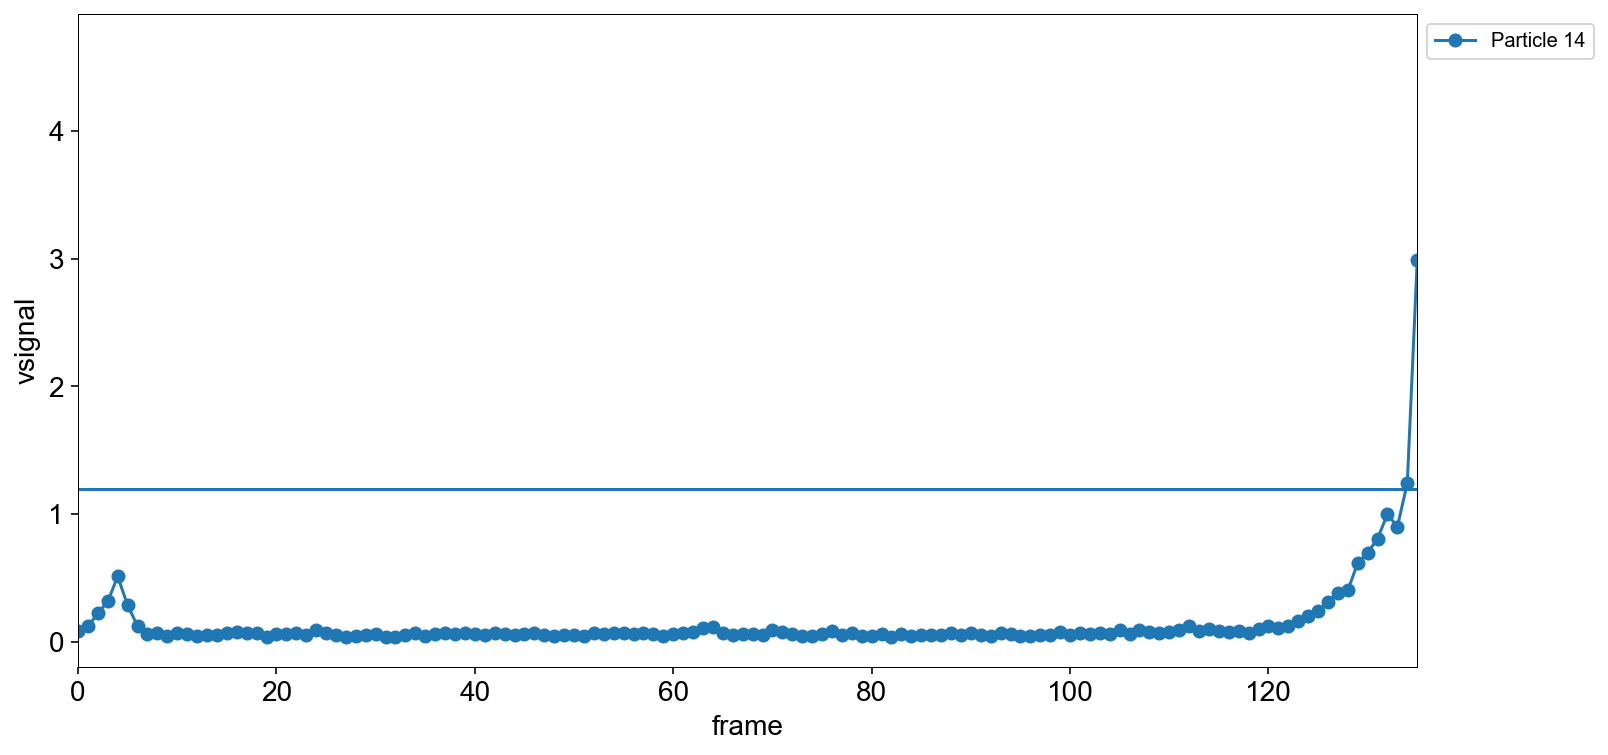

In [187]:
plt.figure(figsize=(12, 6))

particle = 14
mask = final_droplets['particle'] == particle
data = final_droplets[mask]
plt.plot(data['frame'], data['vsignal'], '-o', label=f'Particle {particle}')
plt.xlim(0,135)

plt.axhline(y=1.2)
plt.xlabel('frame', fontsize = 14)
plt.ylabel('vsignal', fontsize = 14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

#plt.show()


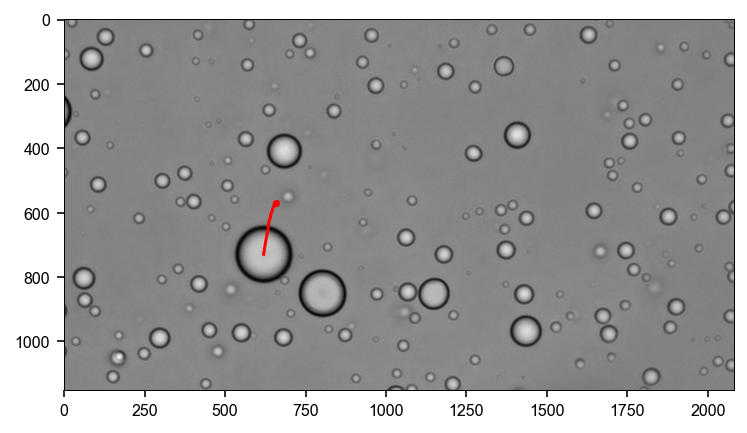

In [180]:
#particle = 14
ipart =  particle
idx = (final_droplets['particle']==ipart)

plt.imshow(imgs[0], cmap='gray')
plt.plot(final_droplets[idx]['x'].values, final_droplets[idx]['y'].values, 'r');

In [278]:
final_droplets['vacuole'] = np.where(final_droplets['vsignal'] > 1.2, 'yes', 'no')


In [279]:
final_droplets.to_csv('23.11.21 drop_radius_knots v7 for 24.07.08 final droplets vsignal 1.2 (24.07.08 f02 0 to 2080) v2.csv')

# add another column with actual time points


In [280]:
df_drops = pd.read_csv('23.11.21 drop_radius_knots v7 for 24.07.08 final droplets vsignal 1.2 (24.07.08 f02 0 to 2080) v2.csv')

In [281]:
df_drops.head()

,Unnamed: 0.1,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,radius,vsignal,vacuole
0,0,12,1231.962659,1291.038251,1.219390,0.883465,0.284714,0.267644,1.221296,NaN,0,1,7.096594,0.120669,no
1,1,11,1190.961816,928.982456,1.076128,0.885615,0.277632,0.232106,1.078090,NaN,0,2,5.190842,0.520022,no
2,2,10,1181.987058,1137.963762,1.287133,0.883655,0.279558,0.282081,1.290364,NaN,0,3,6.784743,0.171886,no
3,3,8,893.970414,1957.976331,0.187684,0.880425,0.297710,0.042201,0.191069,NaN,0,4,4.324591,0.181317,no
4,4,7,887.975410,310.967213,0.135488,0.873095,0.301075,0.032206,0.138347,NaN,0,5,4.082041,0.252257,no


## match p value in time column of pH file to time label value in current csv

In [282]:
df_drops = pd.read_csv('23.11.21 drop_radius_knots v7 for 24.07.08 final droplets vsignal 1.2 (24.07.08 f02 0 to 2080) v2.csv')

In [283]:
df_drops['time_label'] = np.nan


for index, row in df_drops.iterrows():
    #index_frame = (df_drops['particle']==particle) & (df_drops['frame']==0)
    frame_no = df_drops.at[index,'frame']
    #print(frame_no)
    if frame_no < 100:
        df_drops.at[index, 'time_label'] = row['frame'] + 0
    #if frame_no > 134: #and frame_no < 185:
        #df_drops.at[index, 'time_label'] = row['frame'] + 15
    #if frame_no > 184 and frame_no < 490:
        #df_drops.at[index, 'time_label'] = row['frame'] + 521
    #if frame_no > 684:
        #df_drops.at[index, 'time_label'] = row['frame'] + 21


In [284]:
df_drops.head()

,Unnamed: 0.1,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,radius,vsignal,vacuole,time_label
0,0,12,1231.962659,1291.038251,1.219390,0.883465,0.284714,0.267644,1.221296,NaN,0,1,7.096594,0.120669,no,0.0
1,1,11,1190.961816,928.982456,1.076128,0.885615,0.277632,0.232106,1.078090,NaN,0,2,5.190842,0.520022,no,0.0
2,2,10,1181.987058,1137.963762,1.287133,0.883655,0.279558,0.282081,1.290364,NaN,0,3,6.784743,0.171886,no,0.0
3,3,8,893.970414,1957.976331,0.187684,0.880425,0.297710,0.042201,0.191069,NaN,0,4,4.324591,0.181317,no,0.0
4,4,7,887.975410,310.967213,0.135488,0.873095,0.301075,0.032206,0.138347,NaN,0,5,4.082041,0.252257,no,0.0


## change x_loc if analyzing 1000-2080

In [126]:
# add another column for x loc

df_drops['x_v2'] = np.nan


for index, row in df_drops.iterrows():
    ini_x = df_drops.at[index,'x']
    df_drops.at[index, 'x_v2'] = row['x'] + 850

In [28]:
#df_drops['rounded_x_v2'] = df_drops['x_v2'].round()
#df_drops.head()

,Unnamed: 0.1,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,radius,vsignal,vacuole,time_label,x_v2,rounded_x_v2
0,0,0,158.012500,636.018750,0.146889,0.873212,0.295082,0.034886,0.148050,NaN,0,0,2.175421,0.108134,no,10.0,1837.018750,1837.0
1,1,13,1296.005634,723.983099,0.162955,0.888106,0.253571,0.034427,0.164721,NaN,0,1,1.915585,0.098986,no,10.0,1924.983099,1925.0
2,2,12,1218.977667,292.007444,0.554963,0.888303,0.267296,0.117052,0.556134,NaN,0,2,3.464795,0.201340,no,10.0,1493.007444,1493.0
3,3,11,1133.016949,292.966102,0.216661,0.882984,0.282609,0.047739,0.217786,NaN,0,3,2.043052,0.090835,no,10.0,1493.966102,1494.0
4,4,10,1014.033569,184.024735,0.259809,0.884695,0.270880,0.056460,0.260933,NaN,0,4,2.268570,0.144515,no,10.0,1385.024735,1385.0


In [287]:
# Identify columns that start with 'Unnamed:'
unwanted_columns = df_drops.filter(regex='^Unnamed:').columns

# Drop the unwanted columns
df_drops = df_drops.drop(columns=unwanted_columns)

df_drops.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,radius,vsignal,vacuole,time_label,x_v2
0,1342.019876,354.986335,0.506781,0.881134,0.264000,0.113318,0.507574,NaN,0,1,3.155934,0.167313,no,10.0,1204.986335
1,1260.010657,555.964476,0.354432,0.886047,0.260181,0.076175,0.356007,NaN,0,2,2.317595,0.096545,no,10.0,1405.964476
2,1224.025471,175.025471,0.568476,0.881708,0.263533,0.126538,0.569567,NaN,0,3,3.293205,0.075300,no,10.0,1025.025471
3,984.992823,783.007177,0.263148,0.888523,0.242424,0.055400,0.264648,NaN,0,4,2.155811,0.140949,no,10.0,1633.007177
4,1095.969816,665.989501,0.479711,0.886617,0.260434,0.102615,0.481341,NaN,0,6,2.866682,0.118101,no,10.0,1515.989501


In [288]:
x_index = df_drops.columns.get_loc('x')

column_order = list(df_drops.columns)
column_order.remove('x_v2')  # remove the last column from the list
column_order.insert(x_index + 1, 'x_v2')  # insert the last column to the right of 'x'

# reorder the DataFrame based on the new column order
df_drops = df_drops[column_order]